In [9]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
from torch.utils import *
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import gumbel_softmax
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from plot_metrics import plot_jsd, plot_jsd_fred

In [2]:
# Use absolute path
file_path = r"C:\Users\kotsgeo\Documents\GANs\GANs\AMPdata.txt"

class SequenceDataset(Dataset):
    def __init__(self, file_path, seq_length=156):
        self.seq_length = seq_length
        self.sequences = []
        self.char_to_idx = {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}
        
        # Handle both absolute and relative paths
        if not os.path.isabs(file_path):
            file_path = os.path.join(os.getcwd(), file_path)
            
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    seq = line.strip().split('\t')[0]
                    if len(seq) < seq_length:
                        seq = seq + 'P' * (seq_length - len(seq))
                    seq = seq[:seq_length]
                    self.sequences.append(seq)
            print(f"Successfully loaded {len(self.sequences)} sequences")
            
        except FileNotFoundError:
            raise FileNotFoundError(f"Data file not found at: {file_path}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        one_hot = torch.zeros(self.seq_length, len(self.char_to_idx))
        for i, char in enumerate(seq[:self.seq_length]):
            if char in self.char_to_idx:
                one_hot[i][self.char_to_idx[char]] = 1
            else:
                one_hot[i][self.char_to_idx['P']] = 1
        return one_hot

# Test the dataset
if __name__ == "__main__":
    # You can use either relative or absolute path
    # Option 1: Relative path
    dataset = SequenceDataset("AMPdata.txt")
    
    # Option 2: Absolute path
    # dataset = SequenceDataset("/path/to/your/AMPdata.txt")

    # Print first sequence
    first_seq = dataset[0]
    print("First sequence shape:", first_seq.shape)
    print("\nMapping:", dataset.char_to_idx)

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

    print('\nNumber of sequences:', len(dataloader.dataset))
    
    # Check a batch
    for batch in dataloader:
        print("Batch shape:", batch.shape)
        print("\nSample from batch (showing where P padding is):")
        print(torch.argmax(batch[0], dim=1)[:10])  
        break
dataset = SequenceDataset(file_path)

Successfully loaded 2600 sequences
First sequence shape: torch.Size([156, 5])

Mapping: {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}

Number of sequences: 2600
Batch shape: torch.Size([128, 156, 5])

Sample from batch (showing where P padding is):
tensor([1, 2, 3, 3, 3, 3, 2, 2, 1, 3])
Successfully loaded 2600 sequences


In [3]:
class ResBlock(nn.Module):
    def __init__(self, hidden):
        super(ResBlock, self).__init__()
        
        self.hidden_channels = hidden // 4
        
        # Down projection
        self.down_proj = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(True),
            nn.Conv1d(hidden, self.hidden_channels, 1, padding=0)
        )
        
        # Main processing
        self.main_proc = nn.Sequential(
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, self.hidden_channels, 5, padding=2),
            
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, self.hidden_channels, 5, padding=2)
        )
        
        # Up projection
        self.up_proj = nn.Sequential(
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, hidden, 1, padding=0),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        h = self.down_proj(x)
        h = self.main_proc(h)
        h = self.up_proj(h)
        return x + h
    
class ImprovedGenerator(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(ImprovedGenerator, self).__init__()

        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden
        
        # Start from length 5
        self.bottom_length = 5
        
        # Initial projection
        self.linear = nn.Linear(128, hidden*32*self.bottom_length)
        
        # Progressive upsampling blocks
        # 5 -> 10 -> 20 -> 40 -> 80 -> 156
        self.upscale_factors = [2, 2, 2, 2, 1.95]  # Last step adjusts to reach exactly 156
        
        self.blocks = nn.ModuleList([
            # # First block: maintain channels
            nn.Sequential(
                ResBlock(hidden*32),
                nn.Conv1d(hidden*32, hidden*16, 1),              
                nn.Upsample(scale_factor=self.upscale_factors[0])  # 5 -> 10
            ),
            
            # Second block: 16ch → 8ch
            nn.Sequential(
                ResBlock(hidden*16),          
                nn.Conv1d(hidden*16, hidden*8, 1),
                nn.Upsample(scale_factor=self.upscale_factors[1])  # 10 -> 20
            ),
            
            # Third block: 8ch → 4ch
            nn.Sequential(
                ResBlock(hidden*8),           
                nn.Conv1d(hidden*8, hidden*4, 1),
                nn.Upsample(scale_factor=self.upscale_factors[2])  # 20 -> 40
            ),
            
            # Fourth block: 4ch → 2ch
            nn.Sequential(
                ResBlock(hidden*4),           
                nn.Conv1d(hidden*4, hidden*2, 1),
                nn.Upsample(scale_factor=self.upscale_factors[3])  # 40 -> 80
            ),
            
            # Fifth block: 2ch → ch
            nn.Sequential(
                ResBlock(hidden*2),           
                nn.Conv1d(hidden*2, hidden, 1),
                nn.Upsample(scale_factor=self.upscale_factors[4])  # 80 -> 156
            )
        ])
        
        # Final layers
        self.final = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Conv1d(hidden, n_chars, 3, padding=1)
        )

        self.apply(init_weights)

    def forward(self, noise):
        # Initial projection and reshape
        output = self.linear(noise)  # [64, 5120]
        output = output.view(-1, self.hidden*32, self.bottom_length)  # [64, 1024, 5]
        
        # Through progressive blocks
        for block in self.blocks:
            output = block(output)
            
        # Final processing
        output = self.final(output)  # [64, 5, 156]
        
        # Prepare for Gumbel
        output = output.transpose(1, 2)  # [64, 156, 5]
        shape = output.size()
        output = output.contiguous()
        output = output.view(-1, self.n_chars)  # [9984, 5]
        output = gumbel_softmax(output, 0.5)
        
        return output.view(shape)  # Back to [64, 156, 5]

class UNetDiscriminator(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(UNetDiscriminator, self).__init__()

        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden

        # Initial projection
        self.initial_conv = nn.Conv1d(n_chars, hidden, 1)  # ch

        # Encoder
        self.enc1 = nn.Sequential(
            ResBlock(hidden),              # 64
            nn.Conv1d(hidden, hidden*2, 1),# -> 128
            nn.AvgPool1d(2)               # 156 -> 78
        )

        self.enc2 = nn.Sequential(
            ResBlock(hidden*2),           # 128
            nn.Conv1d(hidden*2, hidden*4, 1),# -> 256
            nn.AvgPool1d(2)               # 78 -> 39
        )

        self.enc3 = nn.Sequential(
            ResBlock(hidden*4),           # 256
            nn.Conv1d(hidden*4, hidden*8, 1),# -> 512
            nn.AvgPool1d(2)               # 39 -> 19
        )

        self.enc4 = nn.Sequential(
            ResBlock(hidden*8),           # 512
            nn.Conv1d(hidden*8, hidden*16, 1),# -> 1024
            nn.AvgPool1d(2)               # 19 -> 9
        )

        # Bottleneck
        self.bottleneck = ResBlock(hidden*16)  # 1024

        # Decoder
        self.dec1 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*8, 1),# -> 512
            nn.Upsample(scale_factor=2)    # 9 -> 18
        )
        self.dec1_res = ResBlock(hidden*16)  # After concat (512+512=1024)

        self.dec2 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*8, 1),# -> 512
            nn.Upsample(scale_factor=2)    # 19 -> 38
        )
        self.dec2_conv = nn.Conv1d(hidden*12, hidden*16, 1)  # 768->1024
        self.dec2_res = ResBlock(hidden*16)  # After concat adjust

        self.dec3 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*4, 1),# -> 256
            nn.Upsample(scale_factor=2)    # 39 -> 78
        )
        self.dec3_conv = nn.Conv1d(hidden*6, hidden*8, 1)  # 384->512
        self.dec3_res = ResBlock(hidden*8)  # After concat adjust

        self.dec4 = nn.Sequential(
            ResBlock(hidden*8),           # 512
            nn.Conv1d(hidden*8, hidden*2, 1),# -> 128
            nn.Upsample(scale_factor=2)    # 78 -> 156
        )
        self.dec4_conv = nn.Conv1d(hidden*3, hidden*4, 1)  # 192->256
        self.dec4_res = ResBlock(hidden*4)  # After concat adjust

        # Global output (from bottleneck)
        self.global_output = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),    
            nn.Flatten(),
            nn.Linear(hidden*16, 1)      
        )

        # Pixel-wise output
        self.pixel_output = nn.Conv1d(hidden*4, 1, 1)

        self.apply(init_weights)

    def pad_end(self, x, target_size):
        """Add padding at the end to reach target_size"""
        diff = target_size - x.size(2)
        if diff > 0:
            return F.pad(x, (0, diff), mode='constant', value=0)
        return x
    
    def forward(self, input):
        # Input shape: (batch_size, seq_len, n_chars)
        x = input.transpose(1, 2)  # (batch_size, n_chars, seq_len)

        # Initial projection
        x = self.initial_conv(x)  # [batch, hidden, 156]
        residuals = [x]

        # Encoder path
        x = self.enc1(x)        # -> 78
        residuals.append(x)
        x = self.enc2(x)        # -> 39
        residuals.append(x)
        x = self.enc3(x)        # -> 19
        residuals.append(x)
        x = self.enc4(x)        # -> 9

        # Bottleneck
        bottleneck = self.bottleneck(x)  # Store bottleneck output

        # Global output
        global_output = self.global_output(bottleneck)
        global_output = torch.sigmoid(global_output)

        # Decoder path with padding and skip connections
        x = self.dec1(bottleneck)  # 9 -> 18
        x = self.pad_end(x, 19)    # pad to 19
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec1_res(x)

        x = self.dec2(x)           # 19 -> 38
        x = self.pad_end(x, 39)    # pad to 39
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec2_conv(x)      # Adjust channels
        x = self.dec2_res(x)

        x = self.dec3(x)           # 39 -> 78
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec3_conv(x)      # Adjust channels
        x = self.dec3_res(x)

        x = self.dec4(x)           # 78 -> 156
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec4_conv(x)      # Adjust channels
        x = self.dec4_res(x)

        # Pixel-wise output
        pixel_output = self.pixel_output(x)
        pixel_output = torch.sigmoid(pixel_output)
        pixel_output = pixel_output.transpose(1, 2)

        return global_output, pixel_output

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
def random_vector_boundingbox(length, lam):
    # Calculate box length based on lambda
    r = np.sqrt(1. - lam)
    box_length = int(length * r)
    
    # Randomly select start position
    start = np.random.randint(0, length - box_length + 1)
    
    # Calculate end position
    end = start + box_length
    
    return start, end

def create_cutmix_mask(real_sequences, lam=None):
    batch_size, seq_len = real_sequences.size(0), real_sequences.size(1)
    
    # Create mask for each sequence in the batch
    masks = []
    for i in range(batch_size):
        # Generate lambda if not provided
        if lam is None:
            lam = np.random.beta(1, 1)
        
        # Create mask for this sequence
        mask = torch.ones(seq_len)
        start, end = random_vector_boundingbox(seq_len, lam)
        mask[start:end] = 0
        
        # 50% chance to flip mask
        if torch.rand(1) > 0.5:
            mask = 1 - mask
        
        masks.append(mask)
    
    # Stack masks and add channel dimension
    return torch.stack(masks).unsqueeze(-1).to(real_sequences.device)

In [6]:
from seq_analysis import sample_and_analyze, analyze_sequences, save_analysis
from JSD import jsd
from FRED import FREDCalculator

# # Initialize FReD calculator
fred_calculator = FREDCalculator()

# Define results directory with absolute path
results_dir = r"C:\Users\kotsgeo\Documents\GANs\GANs\ResultsNoReg"

n_chars = 5
seq_len = 156
batch_size = 128
hidden_g = 128
hidden_d = 64
num_epochs = 150

generator = ImprovedGenerator(n_chars, seq_len, batch_size, hidden_g).to(device)
discriminator = UNetDiscriminator(n_chars, seq_len, batch_size, hidden_d).to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.9, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005, betas=(0.9, 0.999))

d_scheduler = CosineAnnealingLR(d_optimizer, T_max=num_epochs, eta_min=1e-6)
g_scheduler = CosineAnnealingLR(g_optimizer, T_max=num_epochs, eta_min=1e-6)

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def train_step(discriminator, real_sequences, fake_sequences, mixed_sequences, mask, optimizer, lambda_dec=1):
    batch_size = real_sequences.size(0)

    # Get predictions for real and fake
    real_global, real_pixel = discriminator(real_sequences)
    fake_global, fake_pixel = discriminator(fake_sequences)
    mixed_global, mixed_pixel = discriminator(mixed_sequences)
    
    # Calculate losses
    enc_loss = -torch.mean(torch.log(real_global + 1e-8) +
                      torch.log(1 - fake_global + 1e-8) +
                      torch.log(1 - mixed_global + 1e-8))

    dec_loss = -torch.mean(
        torch.log(real_pixel + 1e-8) +
        torch.log(1 - fake_pixel + 1e-8) +
        torch.log(mixed_pixel * mask + 1e-8) +
        torch.log(1 - mixed_pixel * (1 - mask) + 1e-8)
    )

    # Total discriminator loss
    total_loss = enc_loss + lambda_dec*dec_loss 

    # Update weights
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)

    # Add gradient clipping here
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

    optimizer.step()

    return {
        'enc_loss': enc_loss.item(),
        'dec_loss': dec_loss.item(),
        'total_loss': total_loss.item()
    }

def generator_step(generator, discriminator, batch_size, optimizer):
    # Generate fake sequences
    noise = torch.randn(batch_size, 128).to(device)
    fake_sequences = generator(noise)

    # Get discriminator predictions
    fake_global, fake_pixel = discriminator(fake_sequences)

    # Generator loss

    # Diversity penalty
    diversity_loss = -torch.mean(torch.abs(torch.diff(fake_sequences, dim=1)))

    # Global loss
    g_global_loss = -torch.mean(torch.log(fake_global + 1e-8))

    # Pixel-wise loss
    g_pixel_loss = -torch.mean(torch.log(fake_pixel + 1e-8))

    # Total generator loss
    g_loss = g_global_loss + g_pixel_loss #+ 1*diversity_loss 

    # Update weights
    optimizer.zero_grad()
    g_loss.backward()

    # Add gradient clipping here
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
    
    optimizer.step()

    return {
        'g_global_loss': g_global_loss.item(),
        'g_pixel_loss': g_pixel_loss.item(),
        'g_total_loss': g_loss.item()
    }

def train(generator, discriminator, dataloader, num_epochs, d_step, lambda_dec, g_step=1):
    # Initialize JSD score
    jsd_history = []

    # Initialize FReD score tracking
    fred_history = []
    
    # Initialize lists to store losses for each iteration
    iteration_losses = {
        # Discriminator Losses
        'total_d_loss': [],
        'enc_loss': [],
        'dec_loss': [],

        # Generator Losses
        'total_g_loss': [],
        'g_global_loss': [],
        'g_pixel_loss': [],
    }

    total_iterations = 0

    # Add time tracking
    start_time = time.time()

    # Function to decode sequences
    inv_charmap = {0:'P', 1:'A', 2:'T', 3:'G', 4:'C'}
    def decode_sequence(seq):
        indices = np.argmax(seq.detach().cpu().numpy(), axis=1)
        return ''.join([inv_charmap[idx] for idx in indices])

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Initialize running averages
        running_losses = {
            'total_d_loss': 0,
            'enc_loss': 0,
            'dec_loss': 0,
            'total_g_loss': 0,
            'g_global_loss': 0,
            'g_pixel_loss': 0
        }
        num_batches = len(dataloader)

        # # Initialize lists to store real and generated sequences for FReD calculation
        # real_seqs_for_fred = []
        # generated_seqs_for_fred = []

        for batch_idx, real_sequences in enumerate(dataloader):
            total_iterations += 1

            real_sequences = real_sequences.to(device)
            batch_size = real_sequences.size(0)

            # Generate fake sequences
            noise = torch.randn(batch_size, 128).to(device)
            fake_sequences = generator(noise)
            
            # Create CutMix mask and mixed sequences
            mask = create_cutmix_mask(real_sequences, lam=0.5)
            mixed_sequences = mask * real_sequences + (1 - mask) * fake_sequences
            
            # Train discriminator multiple times
            d_losses_sum = {
                'total_loss': 0,
                'enc_loss': 0,
                'dec_loss': 0,
                'cons_loss': 0
            }

            # Train discriminator
            for _ in range(d_step):
                d_losses = train_step(discriminator,
                                    real_sequences=real_sequences,
                                    fake_sequences=fake_sequences,
                                    mixed_sequences=mixed_sequences,
                                    mask=mask,
                                    optimizer=d_optimizer,
                                    lambda_dec=lambda_dec)

                # Sum up d_losses
                for key in d_losses:
                    d_losses_sum[key] += d_losses[key]
            
            # Average d_losses over d_steps
            d_losses_avg = {k: v/d_step for k, v in d_losses_sum.items()}
            
            # Train generator multiple times
            g_losses_sum = {
                'g_total_loss': 0,
                'g_global_loss': 0,
                'g_pixel_loss': 0
            }

            # Train generator
            for _ in range(g_step):
                g_losses = generator_step(generator, discriminator, batch_size, g_optimizer)
            
                # Sum up g_losses
                for key in g_losses:
                    g_losses_sum[key] += g_losses[key]

            # Average g_losses over g_steps
            g_losses_avg = {k: v/g_step for k, v in g_losses_sum.items()}

            # Store iteration losses (using averages)
            iteration_losses['total_d_loss'].append(d_losses_avg['total_loss'])
            iteration_losses['enc_loss'].append(d_losses_avg['enc_loss'])
            iteration_losses['dec_loss'].append(d_losses_avg['dec_loss'])
            iteration_losses['total_g_loss'].append(g_losses_avg['g_total_loss'])
            iteration_losses['g_global_loss'].append(g_losses_avg['g_global_loss'])
            iteration_losses['g_pixel_loss'].append(g_losses_avg['g_pixel_loss'])

            # Update running averages
            running_losses['total_d_loss'] += d_losses_avg['total_loss']
            running_losses['enc_loss'] += d_losses_avg['enc_loss']
            running_losses['dec_loss'] += d_losses_avg['dec_loss']
            running_losses['total_g_loss'] += g_losses_avg['g_total_loss']
            running_losses['g_global_loss'] += g_losses_avg['g_global_loss']
            running_losses['g_pixel_loss'] += g_losses_avg['g_pixel_loss']

            # Print batch progress
            if batch_idx % 10 == 0:
                print(f'Batch [{batch_idx+1}/{num_batches}]')
                print(f'D_total_loss: {d_losses_avg["total_loss"]:.4f}')
                print(f'├─ Enc_loss: {d_losses_avg["enc_loss"]:.4f}')
                print(f'├─ Dec_loss: {d_losses_avg["dec_loss"]:.4f}')
                print(f'G_total_loss: {g_losses_avg["g_total_loss"]:.4f}')
                print(f'├─ G_global_loss: {g_losses_avg["g_global_loss"]:.4f}')
                print(f'└─ G_pixel_loss: {g_losses_avg["g_pixel_loss"]:.4f}\n')

        # Calculate JSD every N epochs (e.g., 5)
        if epoch % 1 == 0:
            current_jsd = jsd(generator, dataloader, num_batches=5)
            jsd_history.append(current_jsd)

        # Decode function
        inv_charmap = {0: 'P', 1: 'A', 2: 'T', 3: 'G', 4: 'C'}
        def decode_sequence(seq):
            indices = np.argmax(seq.detach().cpu().numpy(), axis=1)
            return ''.join([inv_charmap[idx] for idx in indices])

        # Get real sequences from last batch
        real_seqs_for_fred = []
        for seq in real_sequences:  # real_sequences is from last batch
            decoded = decode_sequence(seq)
            cleaned_seq = decoded.replace('P', '')
            if cleaned_seq:
                real_seqs_for_fred.append(cleaned_seq)

        # Generate same number of fake sequences
        generated_seqs_for_fred = []
        with torch.no_grad():
            noise = torch.randn(len(real_seqs_for_fred), 128).to(device)
            fake_sequences = generator(noise)
            for seq in fake_sequences:
                decoded = decode_sequence(seq)
                cleaned_seq = decoded.replace('P', '')
                if cleaned_seq:
                    generated_seqs_for_fred.append(cleaned_seq)

        # Calculate FRED
        try:
            current_fred = fred_calculator.calculate_fred_from_sequences(
                real_seqs_for_fred,
                generated_seqs_for_fred
            )
            fred_history.append(current_fred)
        except Exception as e:
            print(f"Error calculating FRED: {e}")
            if fred_history:
                current_fred = fred_history[-1]
            else:
                current_fred = float('inf')
        
        # Calculate time for this epoch
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time

        # Calculate epoch averages
        avg_losses = {k: v/num_batches for k, v in running_losses.items()}
        
        # Print epoch averages
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Epoch Time: {epoch_time:.2f}s - '
            f'Total Time: {format_time(total_time)} ')
        print(f'D_total_loss: {avg_losses["total_d_loss"]:.4f}')
        print(f'├─ Enc_loss: {avg_losses["enc_loss"]:.4f}')
        print(f'├─ Dec_loss: {avg_losses["dec_loss"]:.4f}')
        print(f'G_total_loss: {avg_losses["total_g_loss"]:.4f}')
        print(f'├─ G_global_loss: {avg_losses["g_global_loss"]:.4f}')
        print(f'└─ G_pixel_loss: {avg_losses["g_pixel_loss"]:.4f}\n')
        print(f'Latest JSD Score: {current_jsd:.4f}')
        print(f'Latest FReD Score: {current_fred:.4f}')
        print(50*"-")
        
        d_scheduler.step()
        g_scheduler.step()
        
        if epoch % 2 == 0:
            generated_seqs = sample_and_analyze(generator, epoch=epoch, device=device)
            save_analysis(generated_seqs, epoch, results_dir=results_dir)

    return iteration_losses, total_iterations, jsd_history, fred_history

Batch [1/20]
D_total_loss: 10.0244
├─ Enc_loss: 1.9583
├─ Dec_loss: 16.1322
G_total_loss: 3.6089
├─ G_global_loss: 0.9618
└─ G_pixel_loss: 2.6470

Batch [11/20]
D_total_loss: 8.4585
├─ Enc_loss: 1.9064
├─ Dec_loss: 13.1040
G_total_loss: 3.4806
├─ G_global_loss: 1.1550
└─ G_pixel_loss: 2.3256

Epoch [1/50] - Epoch Time: 53.49s - Total Time: 00:00:53 
D_total_loss: 8.6391
├─ Enc_loss: 1.9016
├─ Dec_loss: 13.4749
G_total_loss: 3.4457
├─ G_global_loss: 1.1156
└─ G_pixel_loss: 2.3301

Latest JSD Score: 0.5394
Latest FReD Score: 1.7006
--------------------------------------------------
Batch [1/20]
D_total_loss: 7.8124
├─ Enc_loss: 1.8338
├─ Dec_loss: 11.9572
G_total_loss: 3.5073
├─ G_global_loss: 1.1530
└─ G_pixel_loss: 2.3543

Batch [11/20]
D_total_loss: 7.0207
├─ Enc_loss: 1.7713
├─ Dec_loss: 10.4987
G_total_loss: 3.5884
├─ G_global_loss: 1.1833
└─ G_pixel_loss: 2.4051

Epoch [2/50] - Epoch Time: 51.14s - Total Time: 00:01:44 
D_total_loss: 7.5231
├─ Enc_loss: 1.7966
├─ Dec_loss: 11.4530


c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\scipy\spatial\distance.py:1262: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)
c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\numpy\_core\fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\numpy\lib\_function_base_impl.py:557: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\numpy\_core\_methods.py:130: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\kotsgeo\Documents\GANs\GANs\FRED.py:53: RuntimeWa

Error calculating FRED: array must not contain infs or NaNs
Epoch [3/50] - Epoch Time: 40.09s - Total Time: 00:02:24 
D_total_loss: 9.3538
├─ Enc_loss: 2.1476
├─ Dec_loss: 14.4124
G_total_loss: 1.2736
├─ G_global_loss: 0.8432
└─ G_pixel_loss: 0.4304

Latest JSD Score: nan
Latest FReD Score: 1.8129
--------------------------------------------------
Batch [1/20]
D_total_loss: 9.4710
├─ Enc_loss: 1.7518
├─ Dec_loss: 15.4385
G_total_loss: 1.7639
├─ G_global_loss: 1.2309
└─ G_pixel_loss: 0.5330

Batch [11/20]
D_total_loss: 7.9838
├─ Enc_loss: 1.7339
├─ Dec_loss: 12.4999
G_total_loss: 3.4862
├─ G_global_loss: 1.1979
└─ G_pixel_loss: 2.2883

Epoch [4/50] - Epoch Time: 52.53s - Total Time: 00:03:17 
D_total_loss: 7.9340
├─ Enc_loss: 1.7575
├─ Dec_loss: 12.3530
G_total_loss: 2.9445
├─ G_global_loss: 1.2043
└─ G_pixel_loss: 1.7402

Latest JSD Score: 0.5409
Latest FReD Score: 2.0737
--------------------------------------------------
Batch [1/20]
D_total_loss: 7.4531
├─ Enc_loss: 1.7433
├─ Dec_los

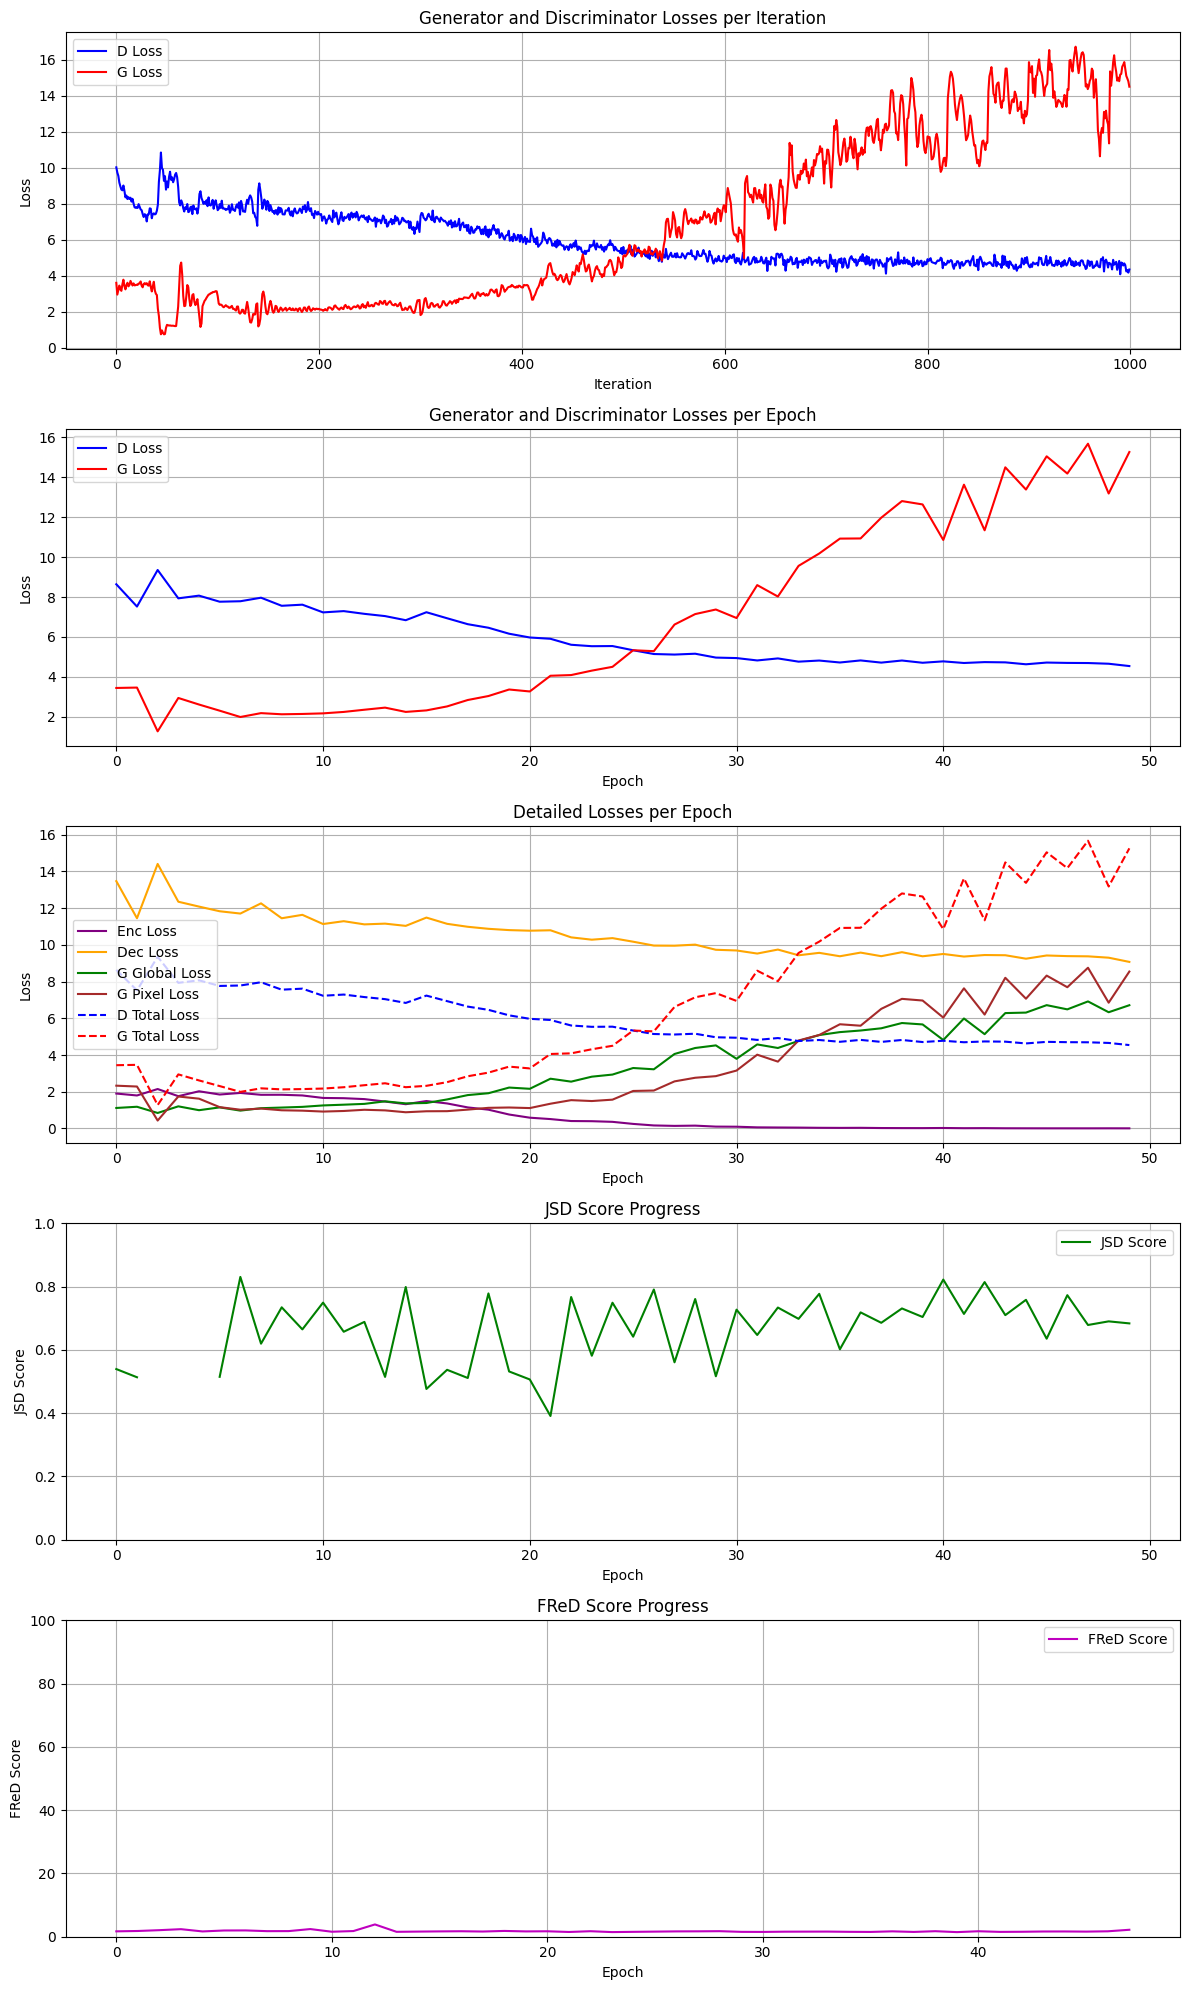

In [7]:
iteration_losses, total_iterations, jsd_history, fred_history = train(generator, discriminator, dataloader,
                                                       num_epochs=50, d_step=2, g_step=3, lambda_dec=0.5)

plot_jsd_fred(
    iteration_losses=iteration_losses,
    jsd_history=jsd_history,
    fred_history=fred_history,
    total_iterations=total_iterations,
    num_epochs=50,
    dataloader_size=len(dataloader)
)